# **SDPA Final Coursework, Part 2**

In [1]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import snscrape.modules.twitter as sntwitter
import re
import yfinance as yf 
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr

### **Step 1: Crawl a base real-world dataset for initial analysis**

The base data of focus for this section of the coursework will be tweet data from the social media platform and digital town square, Twitter. Initially, the plan for the project was to get direct access to the twitter API by applying for an educational account, and to then use the API keys generated by the account to access tweets of a defined specification, but in the end, I was not able to get an account and had to find another way of accessing the Twitter API. 

Instead, the external library 'snscraper' has been implemented in order to retrieve tweets of a defined specification. It works analogous to; and parameters are largely defined similarly to, the native Twitter documentation, but there is no need for API keys, which has meant more effort could be put into development, as opposed to API bureaucracy. More information based on ‘snscraper’ and all other external libraries involved in the project can be found in the README.md. file for Part 2 of the assignment.  

In [9]:
df = pd.read_csv('bitcoin _raw_extracted_tweet_data.csv') # Reading the basic raw data into a dataframe. 

display(df) # Dislaying the 15,000 x 7 dataframe. 

,Date,ID,Text,Username,Reply count,Retweet count,Like count
0,2022-07-28 23:59:54+00:00,1552806084284407808,@BitPaine The opposite of Bitcoin maxis. \n\nT...,spliffymagoo,0.0,0.0,1.0
1,2022-07-28 23:59:49+00:00,1552806060892852224,"Goldman Sachs, JPMorgan Predict Euro-Area Rece...",bitcoinscoops,0.0,0.0,0.0
2,2022-07-28 23:59:48+00:00,1552806058778923013,THREE WHITE SOLDIERS INBOUND EVERYWHERE. #bitcoin,Bobby_5326,1.0,0.0,15.0
3,2022-07-28 23:59:43+00:00,1552806035378913280,Should @GaryGensler be fired or replaced by a ...,Team_Litecoin,0.0,0.0,0.0
4,2022-07-28 23:59:43+00:00,1552806034473127936,@BitMEX Users who trade our FX contracts can p...,nizeiu1945,0.0,0.0,0.0
...,...,...,...,...,...,...,...
14996,2022-12-24 23:53:10+00:00,1606800178576560128,#Bitcoin Last Price $16840 #BTC 🚀\nWeekly Indi...,LivePriceCrypto,0.0,0.0,1.0
14997,2022-12-24 23:53:00+00:00,1606800137917009920,@CryptoTea_ Better going into Bitcoin than crypto,DenverBTCMAXi,1.0,0.0,2.0
14998,2022-12-24 23:52:59+00:00,1606800135358500865,@zetablockchain @Zeta_Nite @Bitcoin @Galxe gra...,akunenko_dima,0.0,0.0,0.0
14999,2022-12-24 23:52:32+00:00,1606800019151269890,"Bitcoin, Binance Coin, Flow, and Aave Daily Pr...",aliffiq94,0.0,0.0,0.0


After building out the project more and with some more consideration, I found the raw scraped data as insufficient for deep and insightful analysis. In the aim of supplementing this base data, additional API scraping and manipulation of Twitter data have been carried out. Such additional steps and enrichment of data will be discussed at length, further into the report. 

### **Step 2a: Perform data preparation & cleaning on the dataset**

The only section of the base dataset that needs cleaning and formatting is the tweet text itself, all other parameters scraped by specification, like date, tweet ID, reply count, retweet count and like count have been scraped to a proper format. In order to remove unnecessary parts and characters from tweet text, a list of regular expressions have been applied to the scraped tweets in an iterative fashion. The pre-defined function below is called and applied to the scraping and the later steps of formatting enriching the data. 

In [77]:
def clean_text(text):
    '''
    Raw textual data from the Twitter API often contain a variety of items that
    make it harder to interpret individual tweets or use them for further analysis, 
    like discerning sentiment. This function removes specific characters and spaces 
    to solve this problem of readability and further application. 
    '''
    
    # Removing @mentions. 
    text = re.sub('@[A-Za-z0–9]+', '', text) 
    
    # Removing '#' hash tags. 
    text = re.sub('#', '', text) 
    
    # Removing RTs. 
    text = re.sub('RT[\s]+', '', text) 
    
     # Removing hyperlinks. 
    text = re.sub('https?:\/\/\S+', '', text)
    
    # Remove punctuation. 
    text = re.sub(r'[^\w\s]', '', text)  
    
    # Remove underscores. 
    text = re.sub(r'_', '', text) 
    
    return text 

### **Step 2b: Generating daily (numerical) averages of existing columns & further enriching data by adding sentiment, subjectivity columns and price data of the specified asset**

As per the specification of the scraping process, 100 tweets of the given keyword 'bitcoin' have been scraped for the past 150 as of 25/11/2022, this totalling into a raw dataset of 15,000 rows of tweet text data and other auxiliary information stored in other columns over the course of the defined period. The raw data scraped for each tweet is not particularly useful in and of itself. For example, the value of a numeric column (e.g, like count, retweet count) on a particular day tells us very little about the overall impression of tweets related to the specific keyword 'bitcoin', a single given tweet might have been particularly popular or unpopular for a variety of reasons. To get a true impression of the average of a numeric figure (e.g, like count, retweet count) on a particular day, it would be far more insightful to get a mean of each of these variables over 100 tweets for each day. To account for this, a mean of each numeric value has been calculated for every 100 values of daily tweets, in the aim of providing a fairer reflection of the general popularity / performance of each tweet. 

The fact that tweet data is text-based data, also means there are potentially a great number of insights to be found in the generation of sentiment and subjectivity figures throught he implementation of sentiment analysis. Sentiment and subjectivity scores allow us to interpret tweets; or groups of tweets, and understand intention behind them, in doing so, we can form an idea of what the public thinks of a particular topic or keyword, in this case, the asset 'bitcoin'. The sentiment analyser VADER has been applied to all tweets to calculate generalised sentiment and an average calculated for all tweets per day (100) has been appended to final dataset as a form of enrichment. The same has been done for subjectivity scores, however a different sentiment analyer 'TexBlob' was used for the purpose of discerning sentiment, as VADER does not provide a native measurement of subjectivity. More information on the library 'nltk', the sentiment analysis tool 'VADER' and all other external libraries involved in the project can be found in the README.md. file for Part 2 of the assignment. In this context, when the term 'mean sentiment' or mean 'subjectivity' is referred to in this assignment, it is in relation to tweet data specifically. 

Finally, BTC data from Yahoo! Finance has also been scraped by calling their API to make comparisons between public sentiment and asset price, its implementation will be covered later in the report. More information on the ‘yfinance’ library and all other external libraries involved in this project can be found in the README.md. file for Part 2 of the assignment

In [78]:
def tweet_scrape_enrich_aggregate():
    
    ''' 
    This function scrapes the Twitter API for 'NoOfTweets' tweets per day over a 'days' day period
    for the keyword 'keyword' using the snscraper external library, and appends all of the raw data to a list named 'whole_data'. 
    The means of other metrics native to Twitter are also calculated for each of the 150 days, e.g 'mean_reply_count_list'. 
    The external sentiment analysis libraries of VADER and TextBlob are also applied to each individual 
    piece of textual data and the means for each day over the total 150 day period are similarly added to their 
    respective lists, e.g 'mean_sentiment_list'. All these refined variables are then concatenated
    into a single dataframe to be analysed later, and then read to a .csv file if not done already. 
    
    '''
    
    import datetime
    # List of dates tweets are retrieved from. 
    # Could use the dates generated by the tweet scraping, but for nicer looking formatting a the datetime library has been implemented instead. 
    dates = []

    # List of mean values of interest that will be appened to iteratively. 
    # To be concatenated into a single dataframe later. 
    mean_reply_count_list = []
    mean_retweet_count_list = []
    mean_like_count_list = []

    # List for mean sentiment and mean subjectivity to be appended to later. 
    mean_sentiment_list = []
    mean_subjectivity_list = []

    # List of all data scraped from Twitter API. 
    whole_data = []


    # Inputs for key parameters, for this project they have been inputted as the following: bitcoin, 100, 150 . 
    # This is here in case other keywords need to be tested, but static variable are fine too. 
    keyword = (input("Please enter a keyword or phrase to focus your search: "))
    NoOfTweets = int(input("Please enter the number of Tweets you would like to analyse per day: "))
    days = int(input("How many of the last days would you like to analyse?:  "))




    # Loop through the last n days, 150 days for this project. 
    for i in range(days):
      # Calculate the date for the current iteration
        start = datetime.datetime.now() - datetime.timedelta(days=i)
        end = datetime.datetime.now() - datetime.timedelta(days=(i-1 ))
        date_str = start.strftime('%Y-%m-%d')

      # Add the date for current iteration to the list of dates. 
        dates.append(date_str)

    # Reverse list of days to get items in chronological order.      
    dates = dates[::-1]


    # First for loop iterating through list of dates previously generated. 
    for date in dates:
        sentiment_scores = []
        subjectivity_scores = []

        # Empty lists for data of each 100 tweets from each day to be appended to. 
        tweet_list = []
        like_count_list = []
        reply_count_list = []
        retweet_count_list = []

        # test
        # print(date) 

        # Second for loop scraping for 100 tweets iteratively for the date of the outer for loop iteration. 
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{keyword} lang:en until:{date}').get_items()):
            if i>=NoOfTweets: 
                break 
            # Appending all raw data from tweet.     
            whole_data.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username, tweet.replyCount, tweet.retweetCount, tweet.likeCount])

            # Adding specific data to list of particular description, to be made into mean lists later. 
            tweet_list.append(tweet.rawContent)
            like_count_list.append(tweet.likeCount)
            reply_count_list.append(tweet.replyCount)
            retweet_count_list.append(tweet.retweetCount)
            
            
        for tweet in tweet_list:
            
            # Apply tweet cleaner to tweets before sentiment analysis for more reliable results. 
            tweet = clean_text(tweet)

            analyser = SentimentIntensityAnalyzer()
            # compound sentiment score from the specific tweet stored in the 'scores' variable using VADER. 
            scores = analyser.polarity_scores(tweet)
            
            # TextBlob object created for tweet iteratively. 
            analysis = TextBlob(tweet)
            
            # Compound sentiment and subjectivity scores append to related lists. 
            sentiment_scores.append(scores['compound'])
            subjectivity_scores.append(analysis.sentiment.subjectivity)
        
        # test
        # print(sentiment_scores)
        

            # Calculate the mean of numerical columns, mean sentiment and subjectivity scores for the day. 
        mean_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        mean_sentiment_list.append(mean_sentiment)

        mean_subjectivity = sum(subjectivity_scores) / len(subjectivity_scores)
        mean_subjectivity_list.append(mean_subjectivity)

        mean_like_count = sum(like_count_list) / len(like_count_list)
        mean_like_count_list.append(mean_like_count)

        mean_reply_count = sum(reply_count_list) / len(reply_count_list)
        mean_reply_count_list.append(mean_reply_count)

        mean_retweet_count = sum(retweet_count_list) / len(retweet_count_list)
        mean_retweet_count_list.append(mean_retweet_count)

            
    # Confirmation that tweet scraping and sentiment analysis process has run successfully. 
    print('Scraping and sentiment analysis complete!')
            
            
            
    # Supplementary keyword list for the final dataframe.      
    keyword_list = [f'{keyword}']*days

    # Add mean sentiment, subjectivity, reply count, retweet countm, like count and price information to the data frame for the keyword 'bitcoin'. 
    df1 = pd.Series(keyword_list, name = 'Keyword')
    df2 = pd.Series(dates, name = 'Date')
    df3 = pd.Series(mean_reply_count_list, name = 'Mean reply count')
    df4 = pd.Series(mean_retweet_count_list, name = 'Mean retweet count')
    df5 = pd.Series(mean_like_count_list, name = 'Mean like count')
    df6 = pd.Series(mean_sentiment_list, name = 'Mean sentiment of daily tweets')
    df7 = pd.Series(mean_subjectivity_list, name = 'Mean subjectivity of daily tweets')
    df8 = pd.Series(market_data(days), name = 'Adjusted closing asset price')
    

    df_bitcoin = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis = 1)
    print(f'df_{keyword_list[0]} created!')
    
    df_bitcoin.to_csv(f'{keyword}_enriched_data.csv', index = False)
    
    
#     # Aggregate raw data for initial csv file. To be commented out if already generated. 

#     df = pd.DataFrame(whole_data)
#     df.columns = ['Date', 'ID', 'Text', 'Username', 'Reply count', 'Retweet count', 'Like count']
#     df.to_csv(f'{keyword}_raw_extracted_data.csv', index = False)
    
    
    
    
    
    return df_bitcoin

In [79]:
def market_data(days): 
    ''' 
    Using the Yahoo! Finance API, this function scrapes the adjusted closing
    market price of Bitcoin for the last 150 days starting from 25/12/2022. 
    Assigns the data to a dataframe, converts it to a list and then returns the converted list. 
    
    '''
    
    # Set necessary variables, in this case time range of interest and target asset name. 
    start = datetime.datetime(2022, 7, 29)
    end = datetime.datetime(2022, 12, 25)
    symbol = 'BTC-GBP'
    
    # Download specific data from Yahoo! Finance to a dataframe, in this case a 6x150 dataframe. 
    df= yf.download(symbol, start=start, end=end)
    
    # Write to csv if necessary, csv already produced so this is commented out. 
    
    # df.to_csv(f'bitcoin_market_data_29722_251222.csv', index = False)

    # Isolate particular column for adjusted market price at close. 
    df = df['Adj Close'][0:days]
    # Change df to a list, so it can be concatenated with all other lists later. 
    
    btc_price_list = df.values.tolist()
    
    return btc_price_list 

In [81]:
# Calling the scrape and refine function to begin the process of scraping and sentiment analysis. 
tweet_scrape_enrich_aggregate()

# At the time, price data for the 25th was not available hence the 'NaN' value in the dataframe, this has since be ammended. 

Please enter a keyword or phrase to focus your search:  bitcoin 
Please enter the number of Tweets you would like to analyse per day:  100
How many of the last days would you like to analyse?:   150


Scraping and sentiment analysis complete!
[*********************100%***********************]  1 of 1 completed
df_bitcoin  created!


,Keyword,Date,Mean reply count,Mean retweet count,Mean like count,Mean sentiment of daily tweets,Mean subjectivity of daily tweets,Adjusted closing asset price
0,bitcoin,2022-07-29,0.87,0.77,3.69,0.100597,0.278271,19552.054688
1,bitcoin,2022-07-30,1.42,1.45,7.00,0.197435,0.316977,19430.144531
2,bitcoin,2022-07-31,1.00,0.31,3.05,0.039936,0.288098,19178.634766
3,bitcoin,2022-08-01,0.74,0.36,2.69,0.117555,0.304834,19024.222656
4,bitcoin,2022-08-02,0.80,0.20,2.91,0.117630,0.316604,18922.662109
...,...,...,...,...,...,...,...,...
145,bitcoin,2022-12-21,0.25,0.02,1.13,0.052238,0.270928,13925.944336
146,bitcoin,2022-12-22,0.94,0.75,3.75,0.162072,0.341690,13981.368164
147,bitcoin,2022-12-23,1.81,1.62,12.79,0.224089,0.351902,13935.910156
148,bitcoin,2022-12-24,2.56,4.58,15.37,-0.002429,0.327548,13978.060547


The enriched dataset above provides the opportunity for far more details and wide-ranging analysis, through the addition of figures from appling sentiment anlysis using VADER and TextBlob on the text of each of tweet, and BTC (Bitcoin) price data from the Yahoo! Finance API. Averages of numeric figures native to Twitter have also been computed to give a better impression of user interaction and tweet performance throughout a given day. 

### **Step 3: Exploratory analysis, computing summary statistics and generating preliminary visualisations**

Summary statistics for all numeric columns of the enriched and formatted data is as follows - 

In [118]:
# Read formatted and enriched data to a dataframe for analysis. 
df = pd.read_csv('bitcoin _enriched_data.csv')

df = df.select_dtypes(include=['int', 'float'])
# Iterate over the columns of the dataframe.
for column in df.columns:
    # Calculate the mean, standard deviation, minimum, maximum and sum values. 
    if column in non_numeric_list: 
        pass 
    
    mean = df[column].mean()
    std = df[column].std()
    min_val = df[column].min()
    max_val = df[column].max()
    sum_val = df[column].sum()

    # Calculate the 25th, 50th, and 75th percentile values.
    q25 = df[column].quantile(0.25)
    q50 = df[column].quantile(0.50)
    q75 = df[column].quantile(0.75)

    # Print the summary statistics for the column.
    print(f'Column: {column}')
    print(f'Mean: {mean}')
    print(f'Std Dev: {std}')
    print(f'Min: {min_val}')
    print(f'Max: {max_val}')
    print(f'Sum: {sum_val}')
    print(f'25th Percentile: {q25}')
    print(f'50th Percentile: {q50}')
    print(f'75th Percentile: {q75}')
    print('  ')


Column: Mean reply count
Mean: 1.5564
Std Dev: 2.20471407085549
Min: 0.2
Max: 20.72
Sum: 233.45999999999998
25th Percentile: 0.6174999999999999
50th Percentile: 0.905
75th Percentile: 1.4849999999999999
  
Column: Mean retweet count
Mean: 1.0541333333333331
Std Dev: 2.1838852105766433
Min: 0.02
Max: 21.73
Sum: 158.12
25th Percentile: 0.21
50th Percentile: 0.47
75th Percentile: 0.9675
  
Column: Mean like count
Mean: 5.731266666666666
Std Dev: 7.803284482854508
Min: 0.72
Max: 77.14
Sum: 859.6899999999998
25th Percentile: 2.0999999999999996
50th Percentile: 3.3
75th Percentile: 6.7225
  
Column: Mean sentiment of daily tweets
Mean: 0.09339448666666664
Std Dev: 0.04723149202032753
Min: -0.010232
Max: 0.224089
Sum: 14.009173
25th Percentile: 0.055648750000000004
50th Percentile: 0.09420400000000001
75th Percentile: 0.12391450000000001
  
Column: Mean subjectivity of daily tweets
Mean: 0.31655903475333325
Std Dev: 0.033537294486504166
Min: 0.224476948
Max: 0.409814087
Sum: 47.483855213
25th

[Text(0.5, 1.0, 'Box plot of native Twitter metrics, averaged over 150 days.'),
 Text(0.5, 0, 'Metric name'),
 Text(0, 0.5, 'Absolute number of metric')]

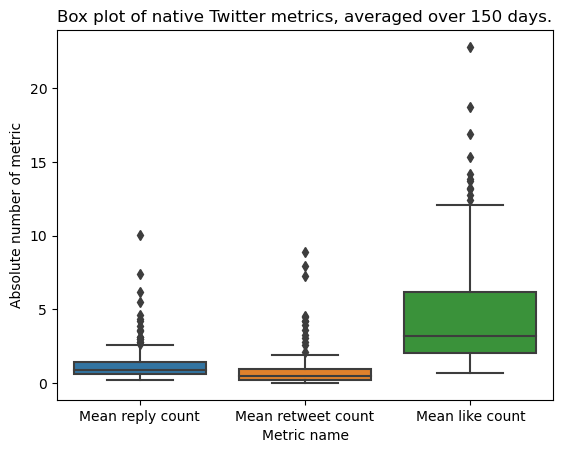

In [25]:
# Visualising summary statistics for metrics of 'success' native to the Twitter platform. 

# Data in columns adjusted / removed where seen fit to better show the distribution. 
columns = ['Mean reply count','Mean retweet count','Mean like count']
df = pd.read_csv('bitcoin _enriched_data_outlier_adjusted.csv', usecols = columns)

sns.boxplot(data = df).set(title = 'Box plot of native Twitter metrics, averaged over 150 days.', xlabel = 'Metric name', ylabel = 'Absolute number of metric')

[Text(0.5, 1.0, 'Box plot of sentiment metrics from Twitter text data of keyword bitcoin, averaged over 150 days.'),
 Text(0.5, 0, 'Metric name'),
 Text(0, 0.5, 'Absolute number of metric')]

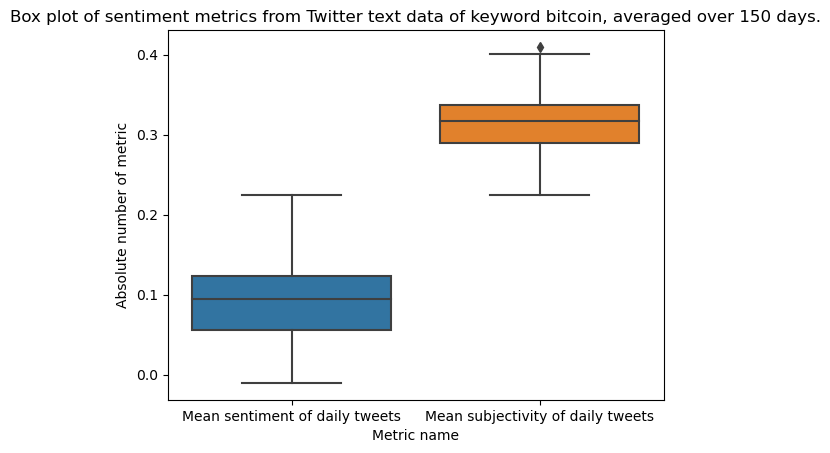

In [26]:
# Visualising summary statistics for metrics associated with the generalised sentiment of Twitter text data. 

columns = ['Mean sentiment of daily tweets', 'Mean subjectivity of daily tweets']
df = pd.read_csv('bitcoin _enriched_data.csv', usecols = columns)

sns.boxplot(data = df).set(title = 'Box plot of sentiment metrics from Twitter text data of keyword bitcoin, averaged over 150 days.', xlabel = 'Metric name', ylabel = 'Absolute number of metric')

[Text(0.5, 1.0, 'Adjusted closing price of bitcoin, over 150 days.'),
 Text(0.5, 0, 'Metric name'),
 Text(0, 0.5, 'Market price in GBP (£)')]

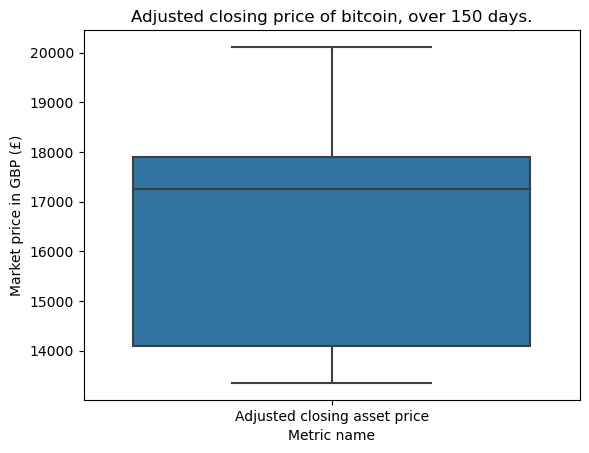

In [28]:
# Visualising summary statistics of the adjusted closing asset price of BTC, 'Bitcoin'. 

columns = ['Adjusted closing asset price']
df = pd.read_csv('bitcoin _enriched_data.csv', usecols = columns)

sns.boxplot(data = df).set(title = 'Adjusted closing price of bitcoin, over 150 days.', xlabel = 'Metric name', ylabel = 'Market price in GBP (£)')

### **Step 4: Asking questions of the enriched and formatted data**

The data of focus at this stage of the assignment will of course be the enriched data that accounts the for means of the numerical figures from the raw tweet data produced using 'snscraper' and other columns of interest, generated using other external libraries, like sentiment and subjectivity scores generated by VADER and TextBlob respectively and price data retrived from the Yahoo! Finance API. 

Below are some of the functions used for the hypothesis testing necessary for the investigation of the questions defined below - 

In [11]:
def pearsonr_tester(v1, v2): 
    
    '''
    Implementation of the Pearson correlation test for parametric distributions. 
    The function takes in two parameters which represent the two columns from 
    the enriched and formatted dataset that you want to see the correlation of. 
    
    '''
    
    print('   ')
    pearsonr_result = pearsonr(v1, v2)
    correlation = pearsonr_result[0]
    pvalue = pearsonr_result[1]
    critical_range = 0.05
                                   
    print(pearsonr_result)

    if  (pearsonr_result[1])< 0.05: 

        print(f'Reject the null hypothesis that is there no statistically significant correlation between the two variables, as the p-value {pvalue} falls outside the critical range {critical_range}')
        print(f'The statistically affirmed correlation between the two variables has been found to be {correlation}.')

    else: 

        print('We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.')
        
    print('  ')
    

In [10]:
def spearmanr_tester(v1, v2): 
    
    '''
    Implementation of the Spearman r correlation test for non-parametric datasets. 
    The function takes in two parameters which represent two columns from 
    the enriched and formatted dataset that you want to see the correlation of. 
    
    '''
    
    # Space printed for the sake of formatting and readability. 
    print('   ')
    spearmanr_result = spearmanr(v1, v2)
    correlation = spearmanr_result[0]
    pvalue = spearmanr_result[1]
    critical_range = 0.05
    print(spearmanr_result)

    if (pvalue < critical_range): 

        print(f'Reject the null hypothesis that is there no statistically significant correlation between the two variables, as the p-value {pvalue} falls outside the critical range {critical_range}.')
        print(f'The statistically affirmed correlation between the two variables has been found to be {correlation}.')

    else: 

        print('We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.')
        
    print('  ')

In [14]:
def normality_tester(column_name):
    ''' 
    In order to know what kind of statistical test(s), e.g
    parametric or non-parametric to use, a test of normality must be 
    implemented. This function uses the Shapiro-Wilk test to do so. 
    The column name from the enriched and formatted dataframe that you 
    want to test for normality must be passed into the function. 
    ''' 

    print("Using Shapiro-Wilk test to test the null hypothesis " +
          "that the data was drawn from a normal distribution:")

    df = pd.read_csv('bitcoin _enriched_data.csv')
    
    statistic, pvalue = stats.shapiro(df[column_name])
    if pvalue < 0.05:
        print("Condition " + "{:}".format(column_name) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("Condition " + "{:}".format(column_name) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")
    
    print('   ')

#### **Question 1a: What is the generalised sentiment and subjectivity of tweets related to the keyword 'bitcoin'?(Dynamic and aggregate analysis)** 

- What might this suggest about the impression the general public has of Bitcoin?

#### **Question 1b: What is the relationship between the daily mean sentiment of tweets related to the keyword 'bitcoin', and mean subjectivity of the same description?**

- Is this correlation statistically significant? 

- How can this be interpreted? And what might it suggest about the nature of tweets? 

The aggregated value of mean sentiment over the recorded 150 days is equal to 0.09339448666666664 .
 


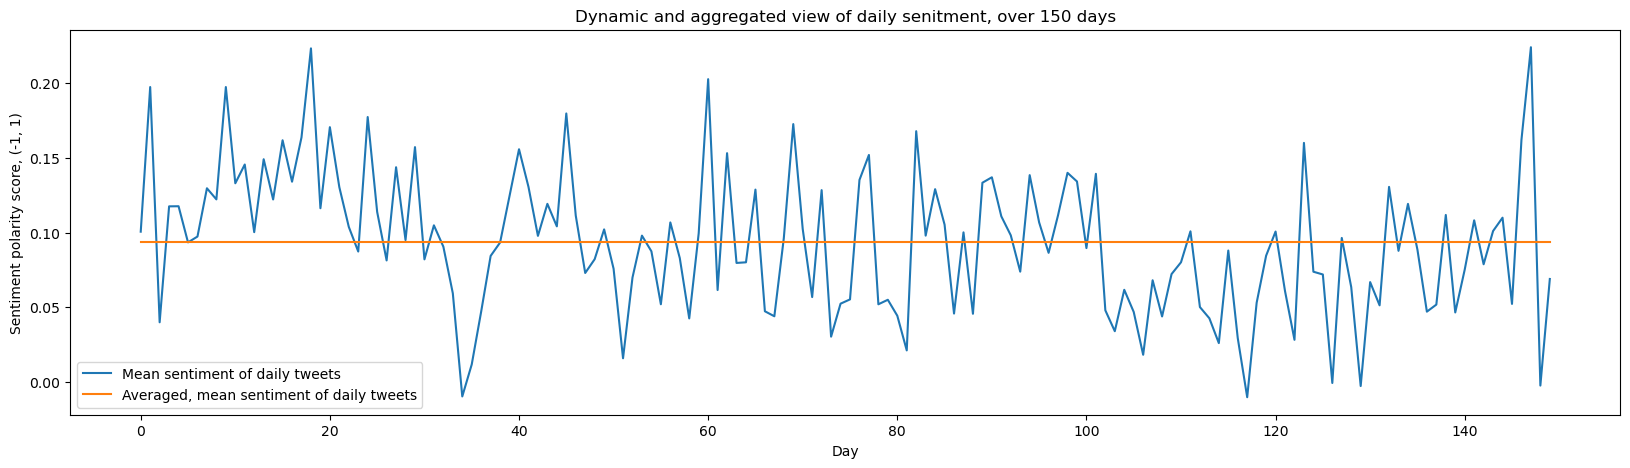

In [81]:
# Question 1a I: 

df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
# Both variables are known to be parametric in naturem, so tests for normality are not necessary. 
v1 = df_bitcoin['Mean sentiment of daily tweets']
mean_v1 = v1.mean()
df_bitcoin['Aggregate sentiment'] = mean_v1

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Mean sentiment of daily tweets').set(title = 'Dynamic and aggregated view of daily senitment, over 150 days', xlabel = 'Day', ylabel = 'Sentiment polarity score, (-1, 1)')
sns.lineplot(x = df_bitcoin.index, y = 'Aggregate sentiment', data = df_bitcoin, label = 'Averaged, mean sentiment of daily tweets').set(title = 'Dynamic and aggregated view of daily senitment, over 150 days', xlabel = 'Day', ylabel = 'Sentiment polarity score, (-1, 1)')

print(f'The aggregated value of mean sentiment over the recorded 150 days is equal to {mean_v1} .')
print(' ')

For the **analysis regarding Question 1 part a I**, it is clear that although fluctuating quite a lot, the overall sentiment regarding the keyword 'bitcoin' is positive, with an aggregate sentiment score of 0.093 (3.d.p) where a score of -1 is entirely negative and a score of 1 is entirely positive, over the entire 150 day period. Although the generated aggregate sentiment score is not extremely high, it still suggests that most of the conversations around Bitcoin on Twitter are somewhat positive in nature; and therefore, Twitter users and perhaps the general population at large, think of Bitcoin in a somewhat favourale light. At least for the last 150 day period. 

The aggregated value of mean sentiment over the recorded 150 days is equal to 0.31655903475333325 .
 


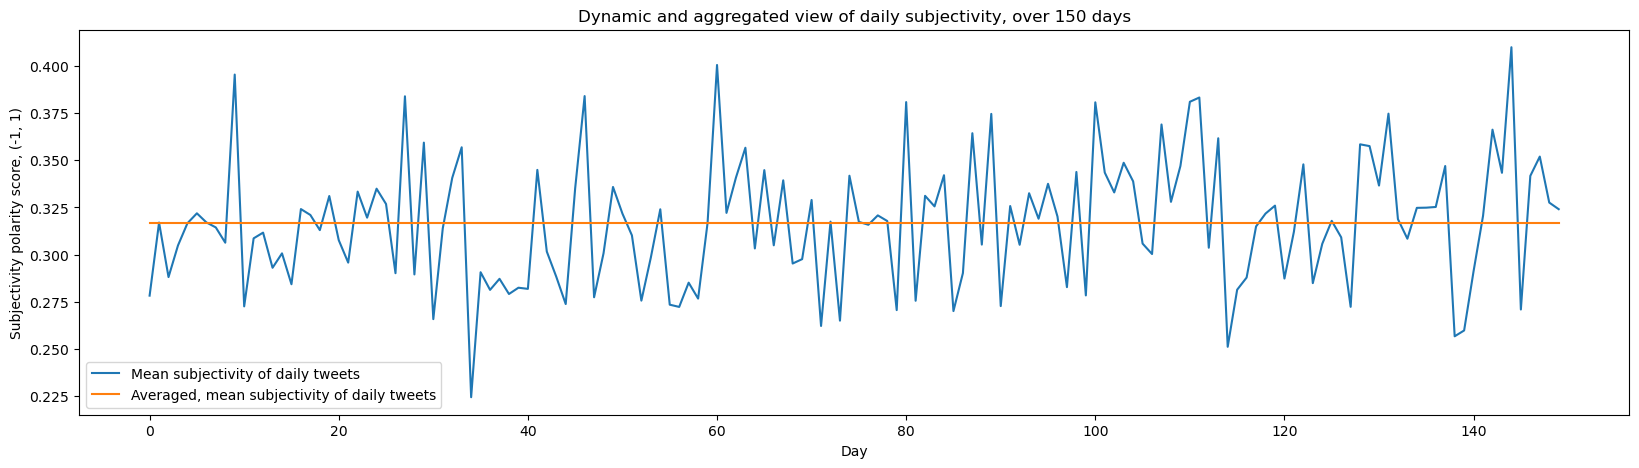

In [82]:
# Question 1a II: 

df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
# Both variables are known to be parametric in naturem, so tests for normality are not necessary. 
v2 = df_bitcoin['Mean subjectivity of daily tweets']
mean_v2 = v2.mean()
df_bitcoin['Aggregate subjectivity'] = mean_v2

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean subjectivity of daily tweets', data = df_bitcoin, label = 'Mean subjectivity of daily tweets').set(title = 'Dynamic and aggregated view of daily subjectivity, over 150 days', xlabel = 'Day', ylabel = 'Subjectivity polarity score, (-1, 1)')
sns.lineplot(x = df_bitcoin.index, y = 'Aggregate subjectivity', data = df_bitcoin, label = 'Averaged, mean subjectivity of daily tweets').set(title = 'Dynamic and aggregated view of daily subjectivity, over 150 days', xlabel = 'Day', ylabel = 'Subjectivity polarity score, (-1, 1)')

print(f'The aggregated value of mean sentiment over the recorded 150 days is equal to {mean_v2} .')
print(' ')

For the **analysis regarding Question 1 part a II**, similarly, it is clear that although fluctuating quite a lot, the overall subjectivity regarding the keyword 'bitcoin' is also positive, with an aggregate subjectivity score of 0.317 (3.d.p) where a score of 0 represents an entirely objective statement and a score of 1 an entirely subjective one, over the entire 150 day period. This positive sentiment score suggests that a small majority of the tweets posted in Twitter regarding the keyword 'bitcoin' are facts and objective statements, rather than opinions  / subjective in nature, over the past 150 days. 

In [ ]:
# Question 1b:

# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# In order to determine what correlation test is best suit for each dataset, a test for normality must first be conducted.
# A Shapiro-Wilk test will be used to determine whether to use a parametric or non-parametric test.  
normality_tester('Mean sentiment of daily tweets')
normality_tester('Mean subjectivity of daily tweets')


Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean sentiment of daily tweets. We cannot reject the null hypothesis (p=0.40). Therefore, data is normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean subjectivity of daily tweets. We cannot reject the null hypothesis (p=0.24). Therefore, data is normally distributed.
   


In [86]:
# Both datasets are found to be parametric in nature, so the Pearson r (correlation) test is suitable.
v1 = df_bitcoin['Mean sentiment of daily tweets']
v2 = df_bitcoin['Mean subjectivity of daily tweets']

# Implementing correlation tester for statistical significance. 
print('Testing the correlation between mean sentiment of daily tweets and mean subjectivity of the same description.')
pearsonr_tester(v1, v2)

Testing the correlation between mean sentiment of daily tweets and mean subjectivity of the same description.
   
PearsonRResult(statistic=0.18766752307468548, pvalue=0.021465645926449436)
Reject the null hypothesis that is there no statistically significant correlation between the two variables, as the p-value 0.021465645926449436 falls outside the critical range 0.05
The statistically affirmed correlation between the two variables has been found to be 0.18766752307468548.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Mean subjectivity of daily tweets')]

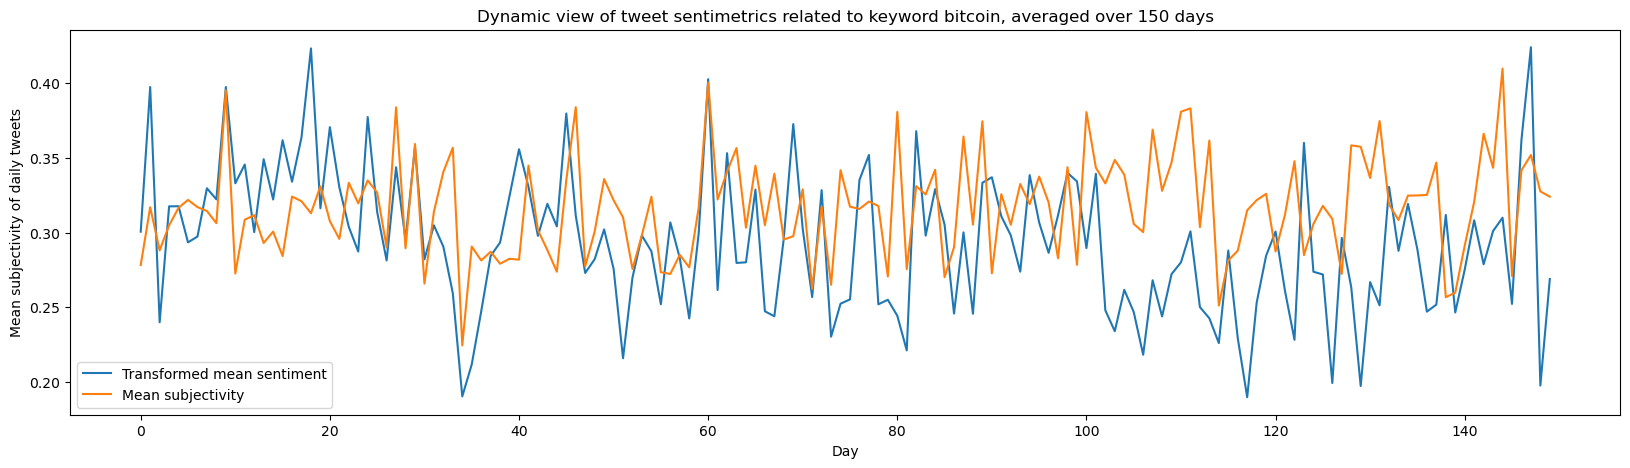

In [84]:
# Mean sentiment has to be scaled a little bit to make the correlation between sentiment and subjectivity clear. 
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] + 0.2

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Transformed mean sentiment').set(title = 'Dynamic view of tweet sentimetrics related to keyword bitcoin, averaged over 150 days', xlabel = 'Day', ylabel = None)
sns.lineplot(x = df_bitcoin.index, y = 'Mean subjectivity of daily tweets', data = df_bitcoin, label = 'Mean subjectivity').set(xlabel = 'Day', ylabel = 'Mean subjectivity of daily tweets')

For the **analysis regarding Question 1b**, it has been shown that there is a statistically significant relationship between the mean sentiment of daily tweets and the mean subjectivity of daily tweets. Though the data analysed is for the keyword 'bitcoin' specifically, it is unlikely that such a relationship would be too wildely different account keywords involving different topics and communites across Twitter. 

Such a relationship is insightful as it shows that the greater the sentiment of any particular tweet is, the more likely is it to be an opinion or subjective in nature. Similarly, if a by higher subjectivity score a tweet is determined to be an opinion, rather than objective fact, it is more likely to be more positive or negative with regards to the language used and overall message; suggesting more objective, factual statements are less polarising in nature with regards to sentiment. Such an observation can also be helpful for contextualising certain debates and online conversations, considering the proven statistically significant; albeit weak correlation of 0.188 (3.d.p), if a certian discussion on Twitter is shown to carry the tweets of strong sentiment polarity, it is likely the conversation itself is relatively more subjective in nature and somewhat dominated by the opinions of users, as opposed to the less polarising, more neutral sentiment of more objective statements. Such a relationship could even be the basis for certain features native to Twitter that aim to judge whether a tweet is subjective or objective in nature. A filter that accounts for the subjectivity score of a tweet, but also the sentiment score; a sentiment score very polarising in nature could suggest subjectivity, could be applied in the aim of discerning opinion pieces from accepted fact. 

#### **Question 2a: What is the relationship between mean like count and the averages of the other two performance metrics native to Twitter - reply and retweet count?**

#### **Question 2b: If mean like count can be thought of as a generalised measure of a given tweet's 'success' on the platform, then do more positively or negatively polarised tweets perform better (sentiment)? And do tweets that are more subjective or objective in nature perform comparatively better(subjectivity)?**

- Are these correlations statistically significant? 

- If so, how can these results be interpreted? And what might it suggest about user behaviour?

In [66]:
# Question 2a:

# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
v1 = df_bitcoin['Mean like count']
v2 = df_bitcoin['Mean reply count']
v3 = df_bitcoin['Mean retweet count']

# Testing the normality for each variable to determine whether to use a parametric or non-parametric test. 
normality_tester('Mean like count')
normality_tester('Mean reply count')
normality_tester('Mean retweet count')

Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean like count. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean reply count. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean retweet count. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   


In [67]:
# All of the three variables native to Twitter have been found to be non-parametric in nature. 
# Therefore a non-parametric correlation test must be implemented, the Spearman r test fits this specification. 

# Calculating the correlation between the daily mean like count and daily mean reply count of the keyword 'bitcoin' over 150 days. 
print('Testing the correlation between the daily mean like count and daily mean reply count.')
# Implementing correlation tester for statistical significance. 
spearmanr_tester(v1, v2)     

# Calculating the correlation between the daily mean like count and daily mean retweet count of the keyword 'bitcoin' over 150 days. 
print('Testing the correlation between the daily mean like count and daily mean retweet count.')
spearmanr_tester(v1, v3)


Testing the correlation between the daily mean like count and daily mean reply count.
   
SpearmanrResult(correlation=0.7452903243783007, pvalue=7.709634595987687e-28)
Reject the null hypothesis that is there no statistically significant correlation between the two variables, as the p-value 7.709634595987687e-28 falls outside the critical range 0.05
The statistically affirmed correlation between the two variables has been found to be 0.7452903243783007.
  
Testing the correlation between the daily mean like count and daily mean retweet count.
   
SpearmanrResult(correlation=0.8870008188994254, pvalue=1.5924904574070564e-51)
Reject the null hypothesis that is there no statistically significant correlation between the two variables, as the p-value 1.5924904574070564e-51 falls outside the critical range 0.05
The statistically affirmed correlation between the two variables has been found to be 0.8870008188994254.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Absolute number of given metric')]

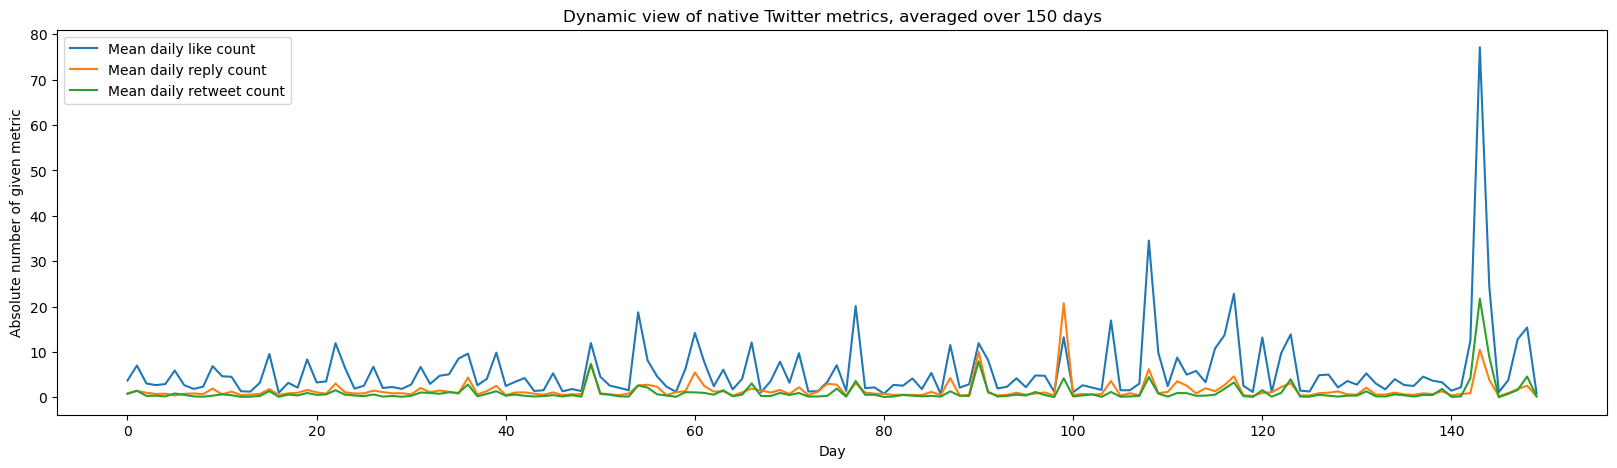

In [68]:
# Plotting line graph to visualise correlation, (transformations applied where necessary). 

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean like count', data = df_bitcoin, label = 'Mean daily like count ').set(title = 'Dynamic view of native Twitter metrics, averaged over 150 days', xlabel = 'Day', ylabel = 'Absolute number of given metric')
sns.lineplot(x = df_bitcoin.index, y = 'Mean reply count', data = df_bitcoin, label = 'Mean daily reply count').set(xlabel = 'Day', ylabel = 'Absolute number of given metric')
sns.lineplot(x = df_bitcoin.index, y = 'Mean retweet count', data = df_bitcoin, label = 'Mean daily retweet count').set(xlabel = 'Day', ylabel = 'Absolute number of given metric')

For the **analysis regarding Question 2 part a**, it has been shown that there is a statisitcally significant relationship between mean like count, and mean reply and retweet count. To be specific, corrlelations of 0.745 (3.d.p) and 0.887 (3.d.p) respectively. This provides insight to user behaviour as it shows that generally speaking, the more likes a given tweet has, the more replies and retweets it will have, but also in a more micro sense, if a given user likes a certain post, they are more likely to reply and much more likely to retweet. 

The presented data is aggregated and therefore does not specifically show that the liking of a tweet consequently affects the probability of a specific user replying and/or retweeting a tweet, however it seems counterintuitive and improbable that a given user would retweet and reply to a post without liking first liking it. Supporting the series of action as something similar to as follows - 1.) Like a tweet, 2.) likely retweet it, 3.) possibly reply to it. Though this very likely is the case for retweets because of how high the correlation coefficient is between likes and retweets, the lower correlation coefficent of replies suggests a potentially contrary case to consider: a user disagrees with the said post and therefore replies (likely with something negative) and does not like the post, which could be a contributing factor for as to why the correlation between likes and replies is weaker. Replying also takes much more effort, as a response has to be manually typed, compared to simply pressing a like or retweet button, meaning the threshold of 'appreciation' a user would have to reach that would justify the particular course of action is higher, likely also contributing to the lower correlation coefficient. Put simply, this discrepancy can be put down to how likes and retweets can be thought of a purely positive metric, while replying to a tweet can be both supportive and critical, while also taking more time and effort (barrier to entry in a way) to perform. It is important to understand that these results are not representive of tweets in general, but rather a very small section of tweets related to the keyword 'bitcoin', the bitcoin maximalist community or those who have an interest in Bitcoin may have comparatively higher rates of engagement when compared to the rest of Twitter, however the difference between such keywords should not be so dissimiilar for such fundamental behaviour. 

In summary, for the keyword 'bitcoin' it has been shown that if a given user likes a tweet, they are very likely to retweet and somewhat likely to reply to it. 

In [63]:
# Question 2b:

# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning variables to later apply Pearson r correlation test to. 
v1 = df_bitcoin['Mean like count']
v2 = df_bitcoin['Mean sentiment of daily tweets']
v3 = df_bitcoin['Mean subjectivity of daily tweets']


Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean sentiment of daily tweets. We cannot reject the null hypothesis (p=0.40). Therefore, data is normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean subjectivity of daily tweets. We cannot reject the null hypothesis (p=0.24). Therefore, data is normally distributed.
   


In [64]:
# Mean like count is known to be non-parametric, but mean sentiment of daily tweets and subjectivty data of the same description have been found to be parametric. 
# Despite the last two variables being parametric, because mean like count is non-pareametric, a non-parametric correlation test must be implemented. 
# The Spearman r test fits this specification. 

print('Testing the correlation between the daily mean like count and mean sentiment of daily tweets.')
spearmanr_tester(v1, v2)

# Calculating the correlation between the daily mean like count and mean subjectivity of daily tweets. 
print('Testing the correlation between the daily mean like count and mean subjectivity of daily tweets.')
spearmanr_tester(v1, v3)

Testing the correlation between the daily mean like count and mean sentiment of daily tweets.
   
SpearmanrResult(correlation=0.05383085718914084, pvalue=0.512950752381278)
We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.
  
Testing the correlation between the daily mean like count and mean subjectivity of daily tweets.
   
SpearmanrResult(correlation=0.04812561837812449, pvalue=0.5586658443725971)
We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Mean daily like count')]

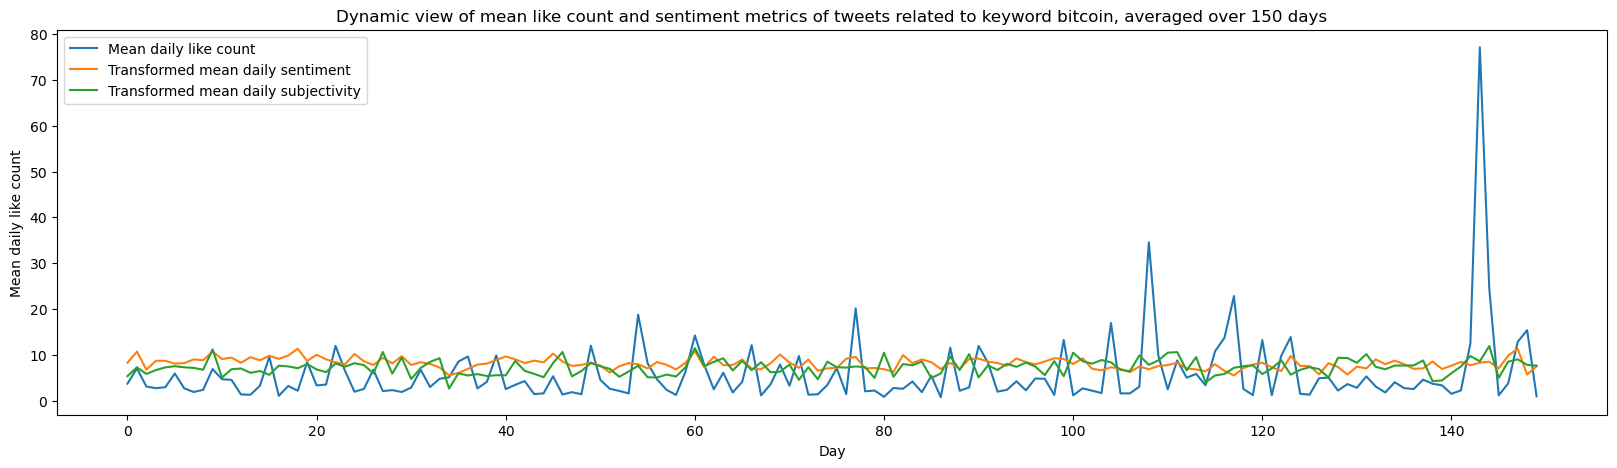

In [65]:
# Mean sentiment and subjectivity scaled in order to view any correlation more closely when visualised. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] * 25
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] + df_bitcoin['Mean like count'].mean()
df_bitcoin['Mean subjectivity of daily tweets'] = df_bitcoin['Mean subjectivity of daily tweets'] * 50
df_bitcoin['Mean subjectivity of daily tweets'] = df_bitcoin['Mean subjectivity of daily tweets'] - (df_bitcoin['Mean like count'].mean())* 1.5

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean like count', data = df_bitcoin, label = 'Mean daily like count ').set(title = 'Dynamic view of mean like count and sentiment metrics of tweets related to keyword bitcoin, averaged over 150 days',xlabel = 'Day', ylabel = 'Absolute number of metric')
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Transformed mean daily sentiment').set(xlabel = 'Day', ylabel = 'Absolute number of metrice')
sns.lineplot(x = df_bitcoin.index, y = 'Mean subjectivity of daily tweets', data = df_bitcoin, label = 'Transformed mean daily subjectivity').set(xlabel = 'Day', ylabel = 'Mean daily like count')

For the **analysis regarding Question 2 part b**, it has been shown that there is no statistically significant relationship between mean like count and mean sentiment of daily tweets or mean subjectivity of daily tweets. 

This provides insight into Twitter user preferences as it shows the likelyhood of a user on Twitter liking a given tweet is not affected very much at all by how apparently positive or negative it is in nature or how much it varies between being more subjecive or objective. It could be easily assumed that more extremely positive or negative tweets; and therefore more polarising tweets, would stand out, garner more views and therefore more likes, but this has shown not to be the case. Similarly, the extent to which a tweet is more subjective or opinion based than objective or fact based does not seem to have a significant effect on the relative 'performance' of a tweet. 

Again, it is important to stress that while it may be the case that users when confronted with a tweets containing the keyword 'bitcoin' are not significantly affected by how positive, negative, subjective or objective the said tweet is, results may differ when tweets related to more polarising keywords like 'politics' are analysed. This perhaps says much more about the blockchain and Bitcoin community on Twitter, than the platform itself, as it is somewhat harder to form a general impression without the context of more keywords across a wide range of topics. 

#### **Question 3: What is the relationship between the daily mean sentiment of tweets with the keyword 'bitcoin' and the adjusted closing price of Bitcoin over the last 150 days? (From 25/12/2022)**

- And if there is a correlation between the two variables, is it statistically significant? 

- How can this resulting correlation be interpreted? What might it suggest? 

In [60]:
# Question 3:
# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
v1 = df_bitcoin['Mean sentiment of daily tweets']
v2 = df_bitcoin['Adjusted closing asset price']

normality_tester('Adjusted closing asset price')

Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Adjusted closing asset price. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   


In [61]:
# Implementing correlation tester for statistical significance. 
print('Testing the correlation between the mean sentiment of daily tweets and the adjusted closing price of Bitcoin, BTC.')
spearmanr_tester(v1, v2)

Testing the correlation between the mean sentiment of daily tweets and the adjusted closing price of Bitcoin, BTC.
   
SpearmanrResult(correlation=0.465786034934886, pvalue=1.8973477451302384e-09)
Reject the null hypothesis that is there no statistically significant correlation between the two variables, as the p-value 1.8973477451302384e-09 falls outside the critical range 0.05
The statistically affirmed correlation between the two variables has been found to be 0.465786034934886.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Market price of BTC')]

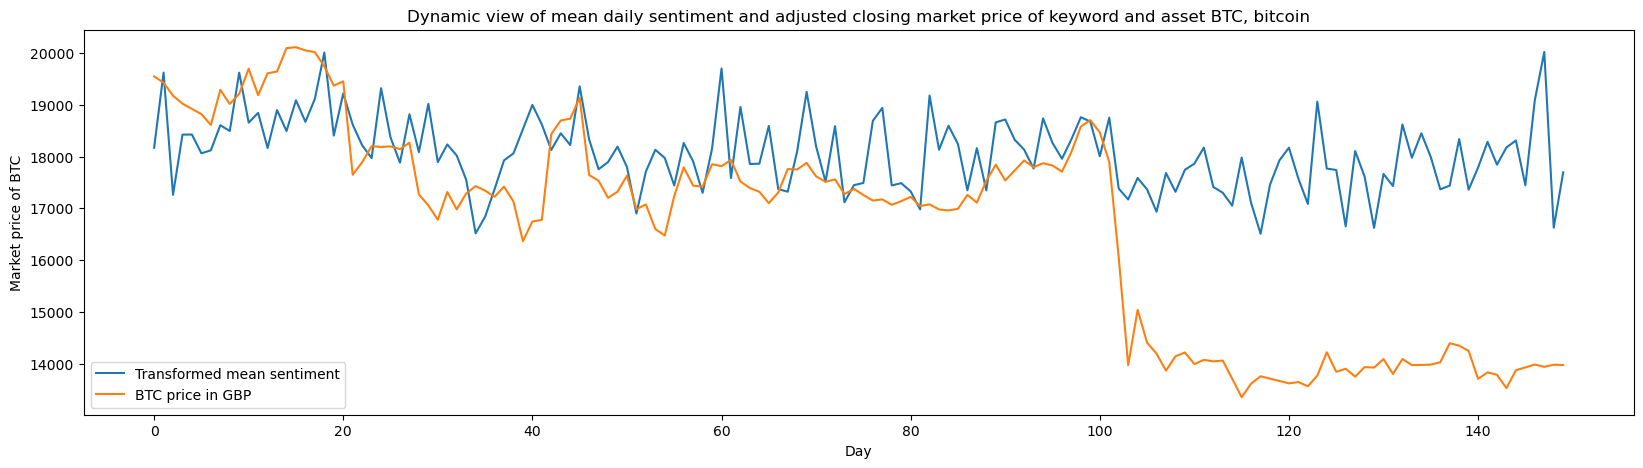

In [62]:
# Mean sentiment has to be transformed to make any potential clear, as the price of bitcoin is many orders of magnitude larger than mean sentiment. 
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets']*15000
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] + df_bitcoin['Adjusted closing asset price'].mean()

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Transformed mean sentiment').set(title = 'Dynamic view of mean daily sentiment and adjusted closing market price of keyword and asset BTC, bitcoin', xlabel = 'Day', ylabel = None)
sns.lineplot(x = df_bitcoin.index, y = 'Adjusted closing asset price', data = df_bitcoin, label = 'BTC price in GBP').set(xlabel = 'Day', ylabel = 'Market price of BTC')


For the **analysis regarding Question 3**, it has been shown that there is a strong statistically significant relationship between the mean sentiment of daily tweets and adjusted closing price of BTC, 'Bitcoin'. 

The relationship between the mean sentiment of daily tweets and the adjusted closing price of BTC has interesting implications, but perhaps not for the reasons one would expect. Despite the relatively strong correlation between the two variables, mean sentiment seems to lag after the price of BTC in a more 'after the fact' fashion, which makes logical sense as it would be expected that the comments made about a given asset would become more negative in nature as it depreciates in value. However, it is this fact that makes mean sentiment an unreliable predicator of asset price, as the strong correlation found is largely a result of how it changes reactively in relation to asset price, trending in a similar manner, but shifted to the right, suggesting certain spikes in mean sentiment do not necessary increase the price of BTC. While this does not mean that changes in mean sentiment have absolutely no effect on the market price of BTC, the relationship is questionable, or weak at best. 

That being said, although mean sentiment may not have great utility when used as a predicative indicator of asset price, it still seems to be a good indicator of generalised investor confidence. Between the days 0 - 102, mean sentiment is shown match asset price closely, although lagging slightly, however on roughly day 102, the price of BTC is shown to fall quite dramatically, but mean sentiment regarding the keyword 'bitcoin' is shown to remain largely constant through this time, despite the market price of BTC showing no signs of recovery in the following days. This sudden shift in relationship between the two variables would suggest that investors; or those who have an interest in bitcoin (enough to tweet about it), still have a level of confidence in BTC as an asset or concept, to the extent that they talk about it positively and support it, suggesting a long-term belief in it as an asset and/or notion. 

From such preliminary analysis, it is clear that while mean sentiment may provide some insights into investor behaviour and confidence, it is still a primitive predictor of BTC's future performance. Correlation does not imply causation: A strong correlation between the sentiment of tweets about bitcoin and the trend of the price of bitcoin does not necessarily mean that one is causing the other. There may be other factors that influence the price of bitcoin and the sentiment of tweets about it and there are many factors that can influence the price of bitcoin itself, including economic conditions, regulatory changes, and relative market demand, it is important to consider these factors when interpreting the correlation between the sentiment of tweets about bitcoin and the trend of the price of bitcoin. That being said, the statistically significant correlation of 0.466 (3.d.p) demonstrates that there is definitely some relationship between mean daily sentiment and the market price of BTC, and when supplemented with other financial signals, sentiment analysis could likely be an insightful measure of the performance of BTC as an asset and maybe even a weak predictor of movements in asset price. 

#### **Summary of findings & conclusions**


Through textual analysis and statistical testing, this report has come to various insights regarding the relationship between variables native to the Twitter platoform, but also other figures related to Twitter textul data and/or related to the keyword 'bitcoin'. The findings of this reports can largley be summarised by the follwing points - 


- Aggregate mean sentiment and subjectivity of tweets with the keyword 'bitcoin' were found to be somewhat positive in nature (although they can both positive, they are interpreted differently as their critical ranges are different). This suggesting that most tweets were favourable of Bitcoin in some way, and were largely factual / objective in nature. 

- Mean sentiment of daily tweets and mean subjectivity of daily tweets were also found to be lightly correlated, suggesting tweets with greater sentiment polarity; whether positive or negative, were found to be more subjective in nature. 

- Mean like count was found to be very strongly correlated to mean retweet count and strongly correlated to mean reply count, suggesting users that like a given post are very likely to retweet the post and somewhat likely to reply to it. However, it must be considered that this phenomenon has only been quantified for tweets containing the keyword 'bitcoin', that being said, it seem unlikely that such a correlation would vary too wildy among keywords of different association and contexts. 

 - There was no statistically significant relationship between sentiment polarity, the level of subjectivity in a tweet and the realtive 'success' of a tweet, measured in like count. This suggesting that more polarising tweets in either sentiment dimension for the keyword 'bitcoin', did not perform any better when compared to other more neutral tweets. 
 
 - While mean sentiment of daily tweets related to the keyword 'bitcoin' alone did not seem to be a good predictor of the market price of Bitcoin, the strong correlation between the two variables suggests that mean sentiment could be used as a good measure of investor confidence in relation to the asset, and when used in conjunction with other financial measures, may even produce a better measure of the viabiliy for Bitcoin as an asset and even a better means of predicting it future price. 
 
 

#### **Future work and potential areas of improvement** 

With regards to further areas of potential research, when making general statements about user behaviour on a platformm like Twitter it is important to study a variety of tweets from a wide ranging number of communities and interests rather than just 'bitcoin', although it seems unlikely that differences in interests would lead to extreme differences in the performance metrics native to Twitter, e.g (like count, retweet count and reply count), it would still be best practice to do so for the sake of completeness. Even when focusing purely on keywords related to cryptocurrencies or blockchain, the investigation the analysis of how other mainstream offerings like Ethereum (ETH), Golem (GNT), etc.. might differ to Bitcoin using this report's methodology could also produce potentially interesting insights. 

Additionally, to better understand the relationship between generalised sentiment and the price movements of Bitcoin, it would likely be better if a longer time period was assessed as opposed to the 150 days sampled in this report. Similarly, to generate a more precise impression of generalised sentiment involving Bitcoin, a sample size of more than 100 tweets per day may also be necessary. 

Finally, having a dataset used for sentiment analysis that has been trained to discern sentiment and subjectivity polarity from tweets specifically, rather than the more general test datasets used by VADER and TextBlob that are not exactly optimised for tweet data specifically, potentially producing polarity scores that are more precise would allow for the public opinion on Twitter to be better understood and make further analyis using such figures to be more reliable and  


To conclude, the following suggestions serve as possible optimisations to this report's currently implemented framework, for the sake of more precise results and a broader understanding of the Twitter platform as a whole. 